In [ ]:
# %pip install -q torchaudio==0.10.0+cu111 -f https://download.pytorch.org/whl/cu111/torch_stable.html
# !pip install torchaudio

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas  as pd
import numpy   as np
import librosa as lb
import seaborn as sbn
import torchaudio
import glob, os
import matplotlib.pyplot as plt
from   scipy   import signal
from   sklearn import svm, metrics
from   sklearn import naive_bayes
from   sklearn.model_selection import train_test_split
from   sklearn.preprocessing import MinMaxScaler
from   sklearn.tree import DecisionTreeClassifier
from   sklearn.preprocessing import LabelEncoder
from   sklearn.ensemble import VotingClassifier
from   sklearn.ensemble import RandomForestClassifier
from   sklearn.ensemble import ExtraTreesClassifier
from   imblearn.over_sampling import BorderlineSMOTE
from   imblearn.over_sampling import SMOTE
from   imblearn.under_sampling import RandomUnderSampler
from   imblearn.pipeline  import Pipeline

Parameter definition:

In [ ]:
# filter parameters
l_cut = 120
h_cut = 1800
order = 12

Defining data directory:

In [ ]:
data_path="/content/drive/MyDrive/Respiratory Data" #/Data/Respiratory_Sound_Database"

Reading patients diagnostic info, creating new labels:

In [ ]:
diagnosis_data=pd.read_csv(data_path+'/patient_diagnosis.csv',names=['ID','disease'])
lst=[]
for index,row in diagnosis_data.iterrows():
    if row['disease']=='Healthy':
        condition = 'Healthy'
    else:
        condition = 'Unhealthy'
    lst.append(condition)
diagnosis_data['Condition'] = lst
diagnosis_data.head()

,ID,disease,Condition
0,101,URTI,Unhealthy
1,102,Healthy,Healthy
2,103,Asthma,Unhealthy
3,104,COPD,Unhealthy
4,105,URTI,Unhealthy


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text major ticklabel objects>)

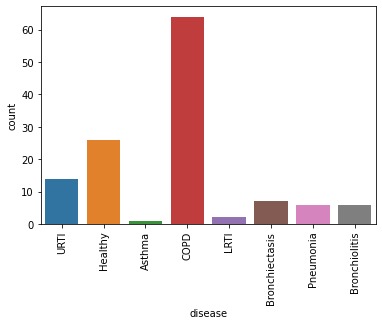

In [ ]:
sbn.countplot(diagnosis_data.disease)
plt.xticks(rotation=90)

Extracting record info from file names:

In [ ]:
#os.chdir(data_path+'/audio_and_txt_files')
os.chdir(data_path)
file_name  = []
patient_id = []
record_inx = []
chest_loc  = []
aqu_mode   = []
record_equ = []

for file in glob.glob('*.txt'):
    name = file.split('.')[0]
    file_name.append(name)
    patient_id.append(name.split('_')[0])
    record_inx.append(name.split('_')[1])
    chest_loc.append(name.split('_')[2])
    aqu_mode.append(name.split('_')[3])
    record_equ.append(name.split('_')[4])

patient_id = [int(i) for i in patient_id]
attributes = list(zip(patient_id,file_name,record_inx,chest_loc,aqu_mode,record_equ))
column     = ['ID','file','Record Ind','Location','Mode','Equipment ']
info_df   = pd.DataFrame(attributes,columns=column)
info_df.head()

,ID,file,Record Ind,Location,Mode,Equipment
0,101,101_1b1_Pr_sc_Meditron,1b1,Pr,sc,Meditron
1,101,101_1b1_Al_sc_Meditron,1b1,Al,sc,Meditron
2,103,103_2b2_Ar_mc_LittC2SE,2b2,Ar,mc,LittC2SE
3,102,102_1b1_Ar_sc_Meditron,1b1,Ar,sc,Meditron
4,104,104_1b1_Ll_sc_Litt3200,1b1,Ll,sc,Litt3200


Combining diagnosis and record info

In [ ]:
info_df = info_df.merge(diagnosis_data,on='ID',how='inner')

In [ ]:
info_df.shape

(11, 8)

# Audio Preprocessing

Defining a function for bandpass filtering:

In [ ]:
def audio_filter(audioArr, sampleRate, l_cut, h_cut, order):
    sos = signal.butter(order, [l_cut, h_cut], 'bandpass', fs=sampleRate, output='sos')
    filtered = signal.sosfilt(sos, audioArr)
    return filtered

In [ ]:
# sos = signal.butter(12,[120,1800],'bandpass',fs=sampleRate,output='sos')
# filtered = signal.sosfilt(sos,audioArr)
# plt.plot(audioArr,'r',label='Raw')
# plt.plot(filtered,'b',label='Filtered')
# plt.legend()

Defining a function to check the lenght of cycles and match the length:

In [ ]:
def cycle_length_match(cyc_audio, sampleRate, req_len_time):

    req_len_sample = sampleRate * req_len_time

    if len(cyc_audio) > req_len_sample:
       cyc_audio_new = cyc_audio[:req_len_sample]

    elif len(cyc_audio) < req_len_sample:
       cyc_audio_new = lb.util.pad_center(cyc_audio, req_len_sample)
    
    return cyc_audio_new 

In [ ]:
#plt.plot(all_data['CycleData'][5])  #zero-padded cycle

Defining a function that receives each audio file and separates breath cycles:

In [ ]:
def audio_slicing(audio_arr, sampleRate, record_data):
    req_len_time = 6 #best cycle length is 6 sec
    data = []
    col = list(['CycleData','crackle','wheeze'])
    for index,row in record_data.iterrows():
        crackle   = int(row['crackle'])
        wheeze    = int(row['wheeze'])
        cyc_start = row['Start']
        cyc_end   = row['End']
        max_ind   = len(audioArr)

        ## Slicing audio file
        start_ind = min(int(cyc_start * sampleRate), max_ind)
        end_ind   = min(int(cyc_end * sampleRate), max_ind) 
        cyc_audio = audioArr[start_ind:end_ind]

        ## length check and zero-pad
        cyc_equal_len = cycle_length_match(cyc_audio, sampleRate, req_len_time)

        data.append(dict(zip(col,[cyc_equal_len.tolist(),crackle,wheeze])))
    audio_df = pd.DataFrame(data)
    return(audio_df)

Reading all audio and txt files and separating cycles of each audio file:

In [ ]:
#os.chdir(data_path+'/audio_and_txt_files')
os.chdir(data_path)
all_data =[]
for index,row in info_df.iterrows():
    
    #load txt file
    record_data=pd.read_csv(row['file']+'.txt',sep='\t', names=['Start','End','crackle','wheeze'])
    
    #load audio
    audioArr,sampleRate=lb.load(row['file']+'.wav')
    
    #filter audio
    filtered_audio = audio_filter(audioArr, sampleRate, l_cut, h_cut, order)
    
    #slicing filtered audio
    audio_df = audio_slicing(filtered_audio, sampleRate, record_data)
    audio_df['ID'] = row['ID']
    audio_df['Fs'] = sampleRate
    
    all_data.append(audio_df)
# downsampling
#if sampleRate > min_sampleRate:
all_data = pd.concat(all_data)
all_data.tail()

,CycleData,crackle,wheeze,ID,Fs
12,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,0,208,22050
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,0,209,22050
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,0,209,22050
2,"[0.050023749470710754, 0.05010179802775383, 0....",0,0,209,22050
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,0,209,22050


Combining separated cycles and other info in a single dataframe:

In [ ]:
all_data = all_data.merge(info_df,on='ID')

In [ ]:
all_data.head()

,CycleData,crackle,wheeze,ID,Fs,file,Record Ind,Location,Mode,Equipment,disease,Condition
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,0,101,22050,101_1b1_Pr_sc_Meditron,1b1,Pr,sc,Meditron,URTI,Unhealthy
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,0,101,22050,101_1b1_Al_sc_Meditron,1b1,Al,sc,Meditron,URTI,Unhealthy
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,0,101,22050,101_1b1_Pr_sc_Meditron,1b1,Pr,sc,Meditron,URTI,Unhealthy
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,0,101,22050,101_1b1_Al_sc_Meditron,1b1,Al,sc,Meditron,URTI,Unhealthy
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,0,101,22050,101_1b1_Pr_sc_Meditron,1b1,Pr,sc,Meditron,URTI,Unhealthy


A sample plot of original audio file and filtered one:

# *Feature* Extraction

In [ ]:
def feature_extraction(preprocessed_audio, fs, win_len, win_hop):

    feature_array = []

    # PSD
    #freq, Pxx_den = signal.periodogram(preprocessed_audio, fs, scaling='density')
    
    # MFCC
    mfccs = lb.feature.mfcc(
        y=preprocessed_audio, sr=fs, win_length=win_len, 
        n_fft=win_len, hop_length=win_hop, n_mfcc=20
        )

    # Chroma STFT
    cstft = lb.feature.chroma_stft(
        y=preprocessed_audio, sr=fs, win_length=win_len, 
        n_fft=win_len, hop_length=win_hop
        )

    #Zero-crossing rate
    zc_rate = lb.feature.zero_crossing_rate(
        y=preprocessed_audio, frame_length=win_len, 
        hop_length=win_hop
        )
    
    feature_array = np.concatenate(
                    (mfccs, cstft, zc_rate)
                    ).T
    
    return feature_array

In [ ]:
#mf,feature = feature_extraction(np.array(all_data.CycleData[2]), sampleRate, win_length, win_hop)
#mf[0,:]

Feature extraction parameters:

In [ ]:
win_length = 2**12  # Why? --> cycle-min-length=8000, 2^12 is the closest binary number
win_hop    = 2**11

In [ ]:
all_sub_features = []
target_labels    = []
subject_ID       = []

for index,row in all_data.iterrows():
    
    # generating target labels
    label = int(row['Condition'] == 'Healthy')

    # Extracting features
    feature = feature_extraction(np.array(row['CycleData']), row['Fs'], win_length, win_hop)

    if index == 0:
      all_sub_features = feature
      target_labels    = np.tile(label,np.shape(feature)[0])
      subject_ID       = np.tile(row['ID'],np.shape(feature)[0])
    else:
      all_sub_features = np.append(all_sub_features,feature,axis=0)
      target_labels    = np.append(target_labels,np.tile(label,np.shape(feature)[0]))
      subject_ID       = np.append(subject_ID, np.tile(row['ID'],np.shape(feature)[0]))

#all_sub_features = np.array(all_sub_features).transpose(1,0,2).reshape(np.shape(all_sub_features)[1],-1).T
#target_labels =  np.reshape(target_labels,(np.shape(all_sub_features)[0],-1))

/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0, 0, 'Unhealthy'), Text(0, 0, 'Healthy')]

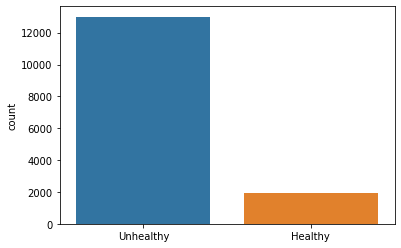

In [ ]:
ax = sbn.countplot(target_labels)
ax.set_xticklabels(['Unhealthy', 'Healthy'])

Processing audio without slicing:

In [ ]:
win_length = 22050  # equal to 1 sec 
win_hop    = 11025

os.chdir(data_path)
all_sub = []
target  = []
sub_ID  = []
req_duration = 20   #20 seconds

for index,row in info_df.iterrows():

    # generating target labels
    label = int(row['Condition'] == 'Healthy')
      
    #load audio
    audioArr,sampleRate=lb.load(row['file']+'.wav')

    #Audio length check
    max_len = req_duration * sampleRate
    if len(audioArr) > max_len:
      audio = audioArr[:max_len]
    elif len(audioArr) < max_len:
      audio = lb.util.pad_center(audioArr, max_len)
    else:
      audio = audioArr

    #filter audio
    filtered_audio = audio_filter(audio, sampleRate, l_cut, h_cut, order)

    #Feature extraction
    feature = feature_extraction(filtered_audio, sampleRate, win_length, win_hop)

    #combining all features
    if index == 0:
      all_sub = feature
      target = np.tile(label,feature.shape[0])
      sub_ID  = np.tile(row['ID'],np.shape(feature)[0])

    else:
      all_sub = np.append(all_sub, feature, axis=0)
      target  = np.append(target,np.tile(label,feature.shape[0]))
      sub_ID  = np.append(sub_ID, np.tile(row['ID'],np.shape(feature)[0]))


# Classification

Building classifier:

In [ ]:
def classification_evaluation(clf, xtest, ytest):
    y_prediction = clf.predict(xtest)
    Accuracy   = metrics.accuracy_score( ytest , y_prediction)
    Precision = metrics.precision_score( ytest , y_prediction)
    Recall    = metrics.recall_score( ytest , y_prediction)
    MAE       = metrics.mean_absolute_error(ytest, y_prediction)
    
    # Confusion Matrix
    conf_matrix = metrics.confusion_matrix(ytest, y_prediction).ravel()

    return [Accuracy,Precision,Recall,MAE]+conf_matrix.tolist()

In [ ]:
def classification(all_features, target_labels):

    xtrain, xtest, ytrain, ytest = train_test_split(all_features,target_labels, test_size = 0.3, stratify=target_labels)

    # SVM - linear
    clf = svm.SVC(kernel = 'linear')
    clf.fit(xtrain,ytrain)
    svm_lin = classification_evaluation(clf, xtest, ytest)

    # SVM - Polynomial
    clf = svm.SVC(kernel = 'poly')
    clf.fit(xtrain,ytrain)
    svm_pol = classification_evaluation(clf, xtest, ytest)

    # SVM - RBF
    clf = svm.SVC(kernel = 'rbf')
    clf.fit(xtrain,ytrain)
    svm_rbf = classification_evaluation(clf, xtest, ytest)

    ### Scaling data for Naive bayes
    scale = MinMaxScaler()
    x_train_n = scale.fit_transform(xtrain)
    x_test_n  = scale.fit_transform(xtest)

    # Naive Bayes - Gaussian
    clf = naive_bayes.GaussianNB()
    clf.fit(x_train_n,ytrain)
    Nab_gau = classification_evaluation(clf, x_test_n, ytest)

    # Naive Bayes - Complement
    clf = naive_bayes.ComplementNB()
    clf.fit(x_train_n,ytrain)
    Nab_cmp = classification_evaluation(clf, x_test_n, ytest)

    # Decision Tree
    clf = DecisionTreeClassifier()
    clf.fit(xtrain,ytrain)
    Dec_Tre = classification_evaluation(clf, xtest, ytest)

    #Random Forest
    clf = RandomForestClassifier(n_estimators = 100)
    clf.fit(xtrain,ytrain)
    Ran_for = classification_evaluation(clf,xtest,ytest)

    #extremely randomized trees
    clf = ExtraTreesClassifier(n_estimators = 100)
    clf.fit(xtrain,ytrain)
    Ext_tre = classification_evaluation(clf,xtest,ytest)

    # Voting
    clf1 = svm.SVC(kernel='rbf')
    clf2 = svm.SVC(kernel='poly')
    clf3 = DecisionTreeClassifier()
    clf4 = RandomForestClassifier(n_estimators = 100)
    eclf = VotingClassifier(estimators =[('a',clf1),('b',clf2),('c',clf3),('d',clf4)])
    eclf.fit(xtrain,ytrain)
    Ens_vot = classification_evaluation(eclf,xtest,ytest)


    lst = [svm_lin,svm_pol,svm_rbf,Nab_gau,Nab_cmp,Dec_Tre,Ran_for,Ext_tre,Ens_vot]
    results = np.array([i + [np.NaN]*(len(lst)-len(i)) for i in lst])
    column  = ['Accuracy','Precision','Recall','MAE','True Neg', 'False Pos', 'False Neg', 'True Pos']
    index   = ['SVM-lin','SVM-polynomial','SVM-RBF','Naive-Gaussian','Naive-Complement','Decision-Tree','Random Forest','Ext Tree','Voting']
    result_df = pd.DataFrame(results, columns =column, index=index)

    return result_df

In [ ]:
def classification2(xtrain,ytrain,xtest,ytest):

    # SVM - linear
    clf = svm.SVC(kernel = 'linear')
    clf.fit(xtrain,ytrain)
    svm_lin = classification_evaluation(clf, xtest, ytest)

    # SVM - Polynomial
    clf = svm.SVC(kernel = 'poly')
    clf.fit(xtrain,ytrain)
    svm_pol = classification_evaluation(clf, xtest, ytest)

    # SVM - RBF
    clf = svm.SVC(kernel = 'rbf')
    clf.fit(xtrain,ytrain)
    svm_rbf = classification_evaluation(clf, xtest, ytest)

    ### Scaling data for Naive bayes
    scale = MinMaxScaler()
    x_train_n = scale.fit_transform(xtrain)
    x_test_n  = scale.fit_transform(xtest)

    # Naive Bayes - Gaussian
    clf = naive_bayes.GaussianNB()
    clf.fit(x_train_n,ytrain)
    Nab_gau = classification_evaluation(clf, x_test_n, ytest)

    # Naive Bayes - Complement
    clf = naive_bayes.ComplementNB()
    clf.fit(x_train_n,ytrain)
    Nab_cmp = classification_evaluation(clf, x_test_n, ytest)

    # Decision Tree
    clf = DecisionTreeClassifier()
    clf.fit(xtrain,ytrain)
    Dec_Tre = classification_evaluation(clf, xtest, ytest)

    #Random Forest
    clf = RandomForestClassifier(n_estimators = 100)
    clf.fit(xtrain,ytrain)
    Ran_for = classification_evaluation(clf,xtest,ytest)

    #extremely randomized trees
    clf = ExtraTreesClassifier(n_estimators = 100)
    clf.fit(xtrain,ytrain)
    Ext_tre = classification_evaluation(clf,xtest,ytest)

    # Voting
    clf1 = svm.SVC(kernel='rbf')
    clf2 = ExtraTreesClassifier(n_estimators = 100)
    clf3 = DecisionTreeClassifier()
    clf4 = RandomForestClassifier(n_estimators = 100)
    eclf = VotingClassifier(estimators =[('a',clf1),('b',clf2),('c',clf3),('d',clf4)])
    eclf.fit(xtrain,ytrain)
    Ens_vot = classification_evaluation(eclf,xtest,ytest)


    lst = [svm_lin,svm_pol,svm_rbf,Nab_gau,Nab_cmp,Dec_Tre,Ran_for,Ext_tre,Ens_vot]
    results = np.array([i + [np.NaN]*(8-len(i)) for i in lst])
    column  = ['Accuracy','Precision','Recall','MAE','True Neg', 'False Pos', 'False Neg', 'True Pos']
    index   = ['SVM-lin','SVM-polynomial','SVM-RBF','Naive-Gaussian','Naive-Complement','Decision-Tree','Random Forest','Ext Tree','Voting']
    result_df = pd.DataFrame(results, columns =column, index=index)

    return result_df

Classification with leave-one-out:

In [ ]:
import warnings
warnings.filterwarnings("ignore")

features = all_sub
labels = target
all_id = sub_ID

final_result = pd.DataFrame(0, index=result_df.index,columns=result_df.columns)
final_zero = pd.DataFrame(0, index=result_df.index,columns=result_df.columns)
final_one = pd.DataFrame(0, index=result_df.index,columns=result_df.columns)

for id in np.unique(all_id):
  print(id)
  xtrain = features[all_id != id]
  ytrain = labels[all_id != id]

  xtest = features[all_id == id]
  ytest = labels[all_id == id]

  oversampler  = SMOTE(sampling_strategy=0.9)
  x1,y1 = oversampler.fit_resample(xtrain,ytrain)
  # undersampler = RandomUnderSampler(sampling_strategy=0.5)
  # x,y = undersampler.fit_resample(x1,y1)

  result_df = classification3(x1,y1,xtest,ytest)
  # result_df.fillna(0,inplace = True)

  final_result = final_result + result_df

  if np.unique(ytest) == 0:
    final_zero = final_zero + result_df
  else:
    final_one = final_one + result_df


mean_df = final_result/len(np.unique(subject_ID))
mean_health = final_one/len(np.unique(subject_ID))
mean_unhealth = final_zero/len(np.unique(subject_ID))

mean_df.columns = ['Performance']


101
102
103
104
105
208
209


In [ ]:
mean_health.columns=['Performance']
mean_unhealth.columns=['Performance']

mean_unhealth

,Performance
SVM-lin,14.285714
SVM-polynomial,28.571429
SVM-RBF,14.285714
Naive-Gaussian,57.142857
Naive-Complement,57.142857
Decision-Tree,0.000000
Random Forest,14.285714
Ext Tree,14.285714
Voting,14.285714


In [ ]:
def classification_evaluation2(clf,xtest,ytest):
  sub_label = ytest[0]
  y_prediction = clf.predict(xtest)
  label = (sum(y_prediction)/len(y_prediction)) > 0.5
  performance = (sub_label == label)*100
  return performance

def classification3(xtrain,ytrain,xtest,ytest):
    # SVM - linear
    clf = svm.SVC(kernel = 'linear')
    clf.fit(xtrain,ytrain)
    svm_lin = classification_evaluation2(clf, xtest, ytest)

    # SVM - Polynomial
    clf = svm.SVC(kernel = 'poly')
    clf.fit(xtrain,ytrain)
    svm_pol = classification_evaluation2(clf, xtest, ytest)

    # SVM - RBF
    clf = svm.SVC(kernel = 'rbf')
    clf.fit(xtrain,ytrain)
    svm_rbf = classification_evaluation2(clf, xtest, ytest)

    ### Scaling data for Naive bayes
    scale = MinMaxScaler()
    x_train_n = scale.fit_transform(xtrain)
    x_test_n  = scale.fit_transform(xtest)

    # Naive Bayes - Gaussian
    clf = naive_bayes.GaussianNB()
    clf.fit(x_train_n,ytrain)
    Nab_gau = classification_evaluation2(clf, x_test_n, ytest)

    # Naive Bayes - Complement
    clf = naive_bayes.ComplementNB()
    clf.fit(x_train_n,ytrain)
    Nab_cmp = classification_evaluation2(clf, x_test_n, ytest)

    # Decision Tree
    clf = DecisionTreeClassifier()
    clf.fit(xtrain,ytrain)
    Dec_Tre = classification_evaluation2(clf, xtest, ytest)

    #Random Forest
    clf = RandomForestClassifier(n_estimators = 100)
    clf.fit(xtrain,ytrain)
    Ran_for = classification_evaluation2(clf,xtest,ytest)

    #extremely randomized trees
    clf = ExtraTreesClassifier(n_estimators = 100)
    clf.fit(xtrain,ytrain)
    Ext_tre = classification_evaluation2(clf,xtest,ytest)

    # Voting
    clf1 = svm.SVC(kernel='rbf')
    clf2 = ExtraTreesClassifier(n_estimators = 100)
    clf3 = DecisionTreeClassifier()
    clf4 = RandomForestClassifier(n_estimators = 100)
    eclf = VotingClassifier(estimators =[('a',clf1),('b',clf2),('c',clf3),('d',clf4)])
    eclf.fit(xtrain,ytrain)
    Ens_vot = classification_evaluation2(eclf,xtest,ytest)


    lst = [svm_lin,svm_pol,svm_rbf,Nab_gau,Nab_cmp,Dec_Tre,Ran_for,Ext_tre,Ens_vot]
    index   = ['SVM-lin','SVM-polynomial','SVM-RBF','Naive-Gaussian','Naive-Complement','Decision-Tree','Random Forest','Ext Tree','Voting']
    result_df = pd.DataFrame(lst, index=index)

    return result_df

In [ ]:
oversampler  = SMOTE(sampling_strategy=0.3)
undersampler = RandomUnderSampler(sampling_strategy=0.2)

steps = [('o', oversampler), ('u', undersampler)]
pipeline = Pipeline(steps=steps)
# transform the dataset
features, labels = pipeline.fit_resample(all_sub_features,target_labels)

result_df = classification(features, labels)

result_df
# x,y = oversampler.fit_resample(all_sub_features,target_labels)
# xx,yy = under.fit_resample(all_sub_features,target_labels)


In [ ]:
oversampler  = SMOTE(sampling_strategy=0.2)
undersampler = RandomUnderSampler(sampling_strategy=0.3)

steps = [('o', oversampler), ('u', undersampler)]
pipeline = Pipeline(steps=steps)
# transform the dataset
features, labels = pipeline.fit_resample(all_sub_features,target_labels)
sbn.countplot(labels)
result_df = classification(features, labels)

result_df

In [ ]:
oversampler  = SMOTE(sampling_strategy=0.3)

# transform the dataset
x,y = oversampler.fit_resample(all_sub_features,target_labels)
sbn.countplot(y)
result_df = classification(x, y)

result_df

In [ ]:
oversampler  = SMOTE(sampling_strategy=0.3)

# transform the dataset
x1,y1 = oversampler.fit_resample(all_sub_features,target_labels)
undersampler = RandomUnderSampler(sampling_strategy=0.5)
x,y = undersampler.fit_resample(x1,y1)

sbn.countplot(y)
result_df = classification(x, y)

result_df

In [ ]:
#
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
print('\033[1mAccuray:','\033[0m','\n\t','%2.4f' %metrics.accuracy_score( ytest , y_prediction),
      '\n\033[1mPrecision:','\033[0m','\n\t','%2.4f' %metrics.precision_score( ytest , y_prediction),
      '\n\033[1mRecall:','\033[0m','\n\t','%2.4f' %metrics.recall_score( ytest , y_prediction),
      '\n\033[1mMAE:','\033[0m','\n\t','%2.4f' %metrics.mean_absolute_error(ytest, y_prediction),'\n')

conf_matrix = metrics.confusion_matrix(ytest, y_prediction)
print('\033[1mConfusion Matrix:','\033[0m\n',conf_matrix)

#print(len(y_prediction))
ax = sbn.countplot(y_prediction)
ax.set_xticklabels(['Unhealthy', 'Healthy'])
b=ax.set_title('Predicted Labels')

In [ ]:
oversampler  = SMOTE(sampling_strategy=0.4)

# transform the dataset
x1,y1 = oversampler.fit_resample(all_sub,target_labels)
undersampler = RandomUnderSampler(sampling_strategy=0.5)
x,y = undersampler.fit_resample(x1,y1)

sbn.countplot(y)
result_df = classification(x, y)

result_df

In [ ]:
feature_array = all_sub_features
label_array = target_labels
ID = subject_ID

### Scaling data for Naive bayes
scale = MinMaxScaler()
#feature_array = scale.fit_transform(feature_array)

sub1 = 102
sub2 = 105
selection = np.logical_and(ID!=sub1,ID!=sub2)

xtrain = feature_array[selection]
ytrain = label_array[selection]

xtest  = feature_array[np.logical_not(selection)] 
ytest  = label_array[np.logical_not(selection)]

oversampler  = SMOTE(sampling_strategy=0.7)
x1,y1 = oversampler.fit_resample(xtrain,ytrain)
#undersampler = RandomUnderSampler(sampling_strategy=0.4)
#x,y = undersampler.fit_resample(x1,y1)
x,y=x1,y1
# steps = [('o', oversampler),('u', undersampler)]
# pipeline = Pipeline(steps=steps)
#transform the dataset
# x, y = pipeline.fit_resample(xtrain,ytrain)
# b_smote = BorderlineSMOTE(sampling_strategy=0.4)
# x,y = b_smote.fit_resample(xtrain,ytrain)

#undersampler = RandomUnderSampler(sampling_strategy=0.6)
#x,y = undersampler.fit_resample(x1,y1)
result_df = classification3(x,y,xtest,ytest)
result_df

,0
SVM-lin,0
SVM-polynomial,0
SVM-RBF,0
Naive-Gaussian,100
Naive-Complement,0
Decision-Tree,0
Random Forest,0
Ext Tree,0
Voting,0


In [ ]:
d = pd.DataFrame(0, index=result_df.index,columns=result_df.columns)
d

,Accuracy,Precision,Recall,MAE,True Neg,False Pos,False Neg,True Pos
SVM-lin,0,0,0,0,0,0,0,0
SVM-polynomial,0,0,0,0,0,0,0,0
SVM-RBF,0,0,0,0,0,0,0,0
Naive-Gaussian,0,0,0,0,0,0,0,0
Naive-Complement,0,0,0,0,0,0,0,0
Decision-Tree,0,0,0,0,0,0,0,0
Random Forest,0,0,0,0,0,0,0,0
Ext Tree,0,0,0,0,0,0,0,0
Voting,0,0,0,0,0,0,0,0


In [ ]:
sbn.countplot(ytrain)
np.unique(sub_ID)

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

# xtrain, xtest, ytrain, ytest = train_test_split(all_sub_features,target_labels, test_size = 0.3, stratify=target_labels)
clf1 = svm.SVC(kernel='rbf')
clf2 = ExtraTreesClassifier(n_estimators = 100)
clf3 = DecisionTreeClassifier()
clf4 = RandomForestClassifier(n_estimators = 100)
eclf = VotingClassifier(estimators =[('a',clf1),('b',clf2),('c',clf3),('d',clf4)])
eclf.fit(xtrain,ytrain)
clf1.fit(x,y)
y_score = clf1.decision_function(xtest)

fpr, tpr, thresholds = roc_curve(np.logical_not(ytest), y_score)
auc = auc(fpr, tpr)
print('auc =', auc)

plt.figure()
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

roc_auc_score(ytest, y_score)